# Imports

In [301]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tf_keras as k
from tf_keras.layers import *
from tf_keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

from modules import train_model, evaluate_preds, save_dict_to_json, plot_loss_and_prediction, get_results_table

import matplotlib.pyplot as plt

# Load Datasets

loading them in pandas

In [302]:
PATH = 'data/'
columns_to_drop = ['Date', 'Open', 'High', 'Low', 'value', 'value_classification']
train_df = pd.read_csv(PATH+'train_dataset.csv').drop(columns=columns_to_drop)
valid_df = pd.read_csv(PATH+'valid_dataset.csv').drop(columns=columns_to_drop)
test_df = pd.read_csv(PATH+'test_dataset.csv').drop(columns=columns_to_drop)

In [303]:
train_df.head(3)

,Volume,Close + 7,Close + 8,Close + 9,Close + 10,Close + 11,Close + 12,Close + 13,Close + 14,Close + 15,...,RSI_3,%K,%D,Close + 6,Close + 5,Close + 4,Close + 3,Close + 2,Close + 1,Close
0,9959400448,11259.400391,11359.400391,10868.400391,10931.400391,11600.099609,12899.200195,11607.400391,11474.900391,11188.599609,...,4.873774,0.000000,2.277774,11171.400391,11440.700195,11786.299805,11296.400391,10106.299805,10221.099609,9170.540039
1,12726899712,11171.400391,11259.400391,11359.400391,10868.400391,10931.400391,11600.099609,12899.200195,11607.400391,11474.900391,...,7.627137,0.000000,2.277774,11440.700195,11786.299805,11296.400391,10106.299805,10221.099609,9170.540039,8830.750000
2,7263790080,11440.700195,11171.400391,11259.400391,11359.400391,10868.400391,10931.400391,11600.099609,12899.200195,11607.400391,...,19.841927,24.753498,8.251166,11786.299805,11296.400391,10106.299805,10221.099609,9170.540039,8830.750000,9174.910156


In [304]:
train_df.columns.values

array(['Volume', 'Close + 7', 'Close + 8', 'Close + 9', 'Close + 10',
       'Close + 11', 'Close + 12', 'Close + 13', 'Close + 14',
       'Close + 15', 'Close + 16', 'Close + 17', 'Close + 18',
       'Close + 19', 'Close + 20', 'Close + 21', 'Close + 22',
       'Close + 23', 'Close + 24', 'Close + 25', 'Close + 26',
       'Close + 27', 'Close + 28', 'Close + 29', 'Close + 30',
       'Close + 31', 'Close + 32', 'Close + 33', 'Close + 34',
       'Close + 35', 'Close + 36', 'Close + 37', 'MA_13', 'MA_21',
       'RSI_3', '%K', '%D', 'Close + 6', 'Close + 5', 'Close + 4',
       'Close + 3', 'Close + 2', 'Close + 1', 'Close'], dtype=object)

turning datasets into np.array

In [305]:
scaler = MinMaxScaler()

In [306]:
columns_to_scale = ['Volume', 'MA_13', 'MA_21', 'RSI_3', '%K', '%D', 'Close + 7', 'Close + 8', 'Close + 9', 'Close + 10',
       'Close + 11', 'Close + 12', 'Close + 13', 'Close + 14',
       'Close + 15', 'Close + 16', 'Close + 17', 'Close + 18',
       'Close + 19', 'Close + 20', 'Close + 21', 'Close + 22',
       'Close + 23', 'Close + 24', 'Close + 25', 'Close + 26',
       'Close + 27', 'Close + 28', 'Close + 29', 'Close + 30',
       'Close + 31', 'Close + 32', 'Close + 33', 'Close + 34',
       'Close + 35', 'Close + 36', 'Close + 37', 'Close + 6', 'Close + 5',
       'Close + 4', 'Close + 3', 'Close + 2', 'Close + 1', 'Close']
train_df[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
valid_df[columns_to_scale] = scaler.transform(valid_df[columns_to_scale])
test_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

X_train, y_train = np.array(train_df.iloc[:, :-7]), np.array(train_df.iloc[:, -7:]) 
X_valid, y_valid = np.array(valid_df.iloc[:, :-7]), np.array(valid_df.iloc[:, -7:]) 
X_test, y_test = np.array(test_df.iloc[:, :-7]), np.array(test_df.iloc[:, -7:])

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_valid = np.reshape(X_valid, (X_valid.shape[0], 1, X_valid.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [307]:
# Fast save function
def fast_save(model, model_name):
    y_train_pred = model.predict(X_train, verbose=0)
    y_valid_pred = model.predict(X_valid, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)
    save_dict_to_json(evaluate_preds(y_train, y_train_pred), filename=f'results/with_technical_indicators/train/{model_name}.json')
    save_dict_to_json(evaluate_preds(y_valid, y_valid_pred), filename=f'results/with_technical_indicators/valid/{model_name}.json')
    save_dict_to_json(evaluate_preds(y_test, y_test_pred), filename=f'results/with_technical_indicators/test/{model_name}.json')

# Training

In [308]:
callback = [k.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')]
metrics=[k.metrics.MeanSquaredError(), 
         k.metrics.RootMeanSquaredError(),
         k.metrics.MeanAbsolutePercentageError(),
         k.metrics.MeanAbsoluteError()]
loss_fn = k.losses.MeanAbsoluteError()

## LSTM

In [309]:
tf.random.set_seed(42)
model_0 = Sequential([
    LSTM(units=64, 
         input_shape=(1, X_train.shape[2]), 
         activation='relu'),
    Dense(units=7)
])

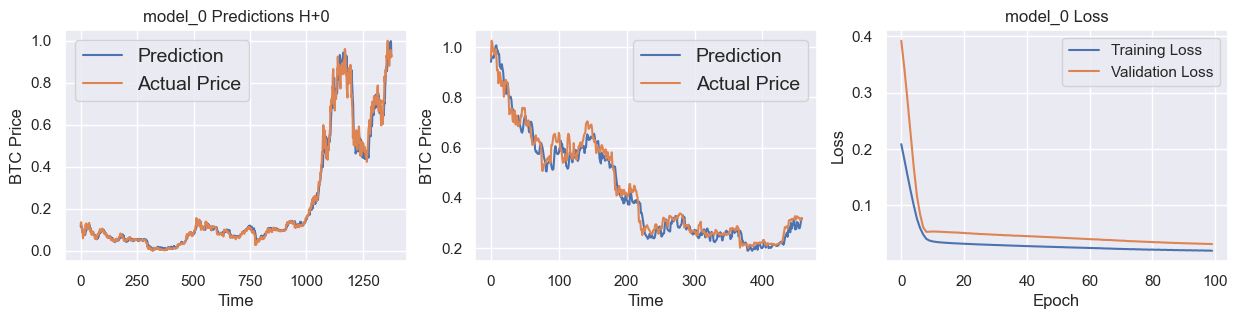

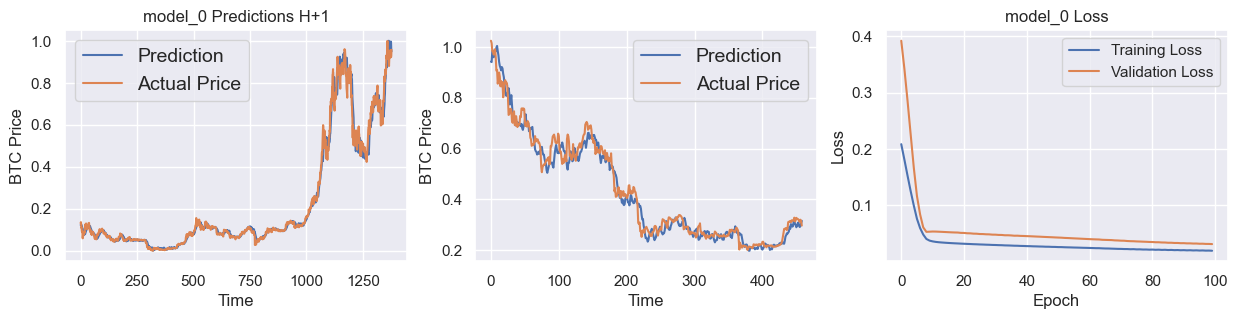

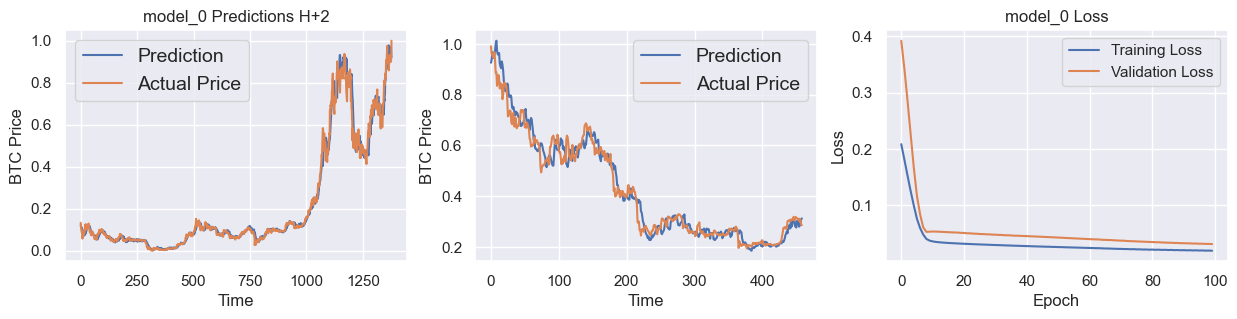

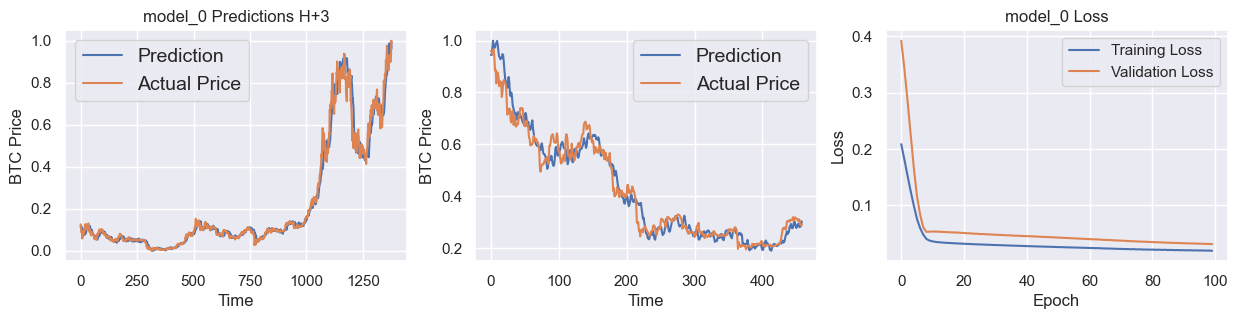

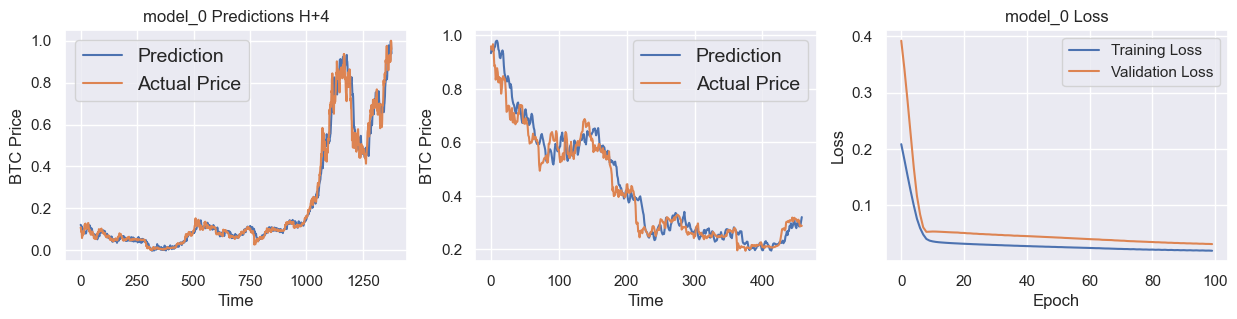

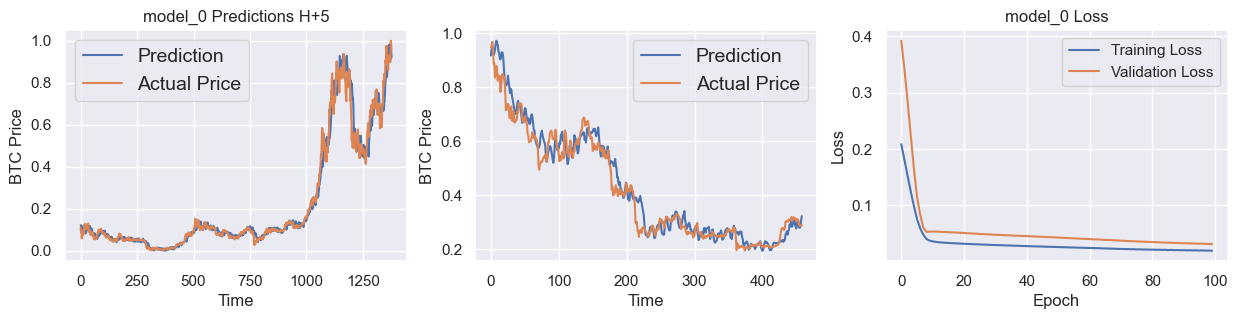

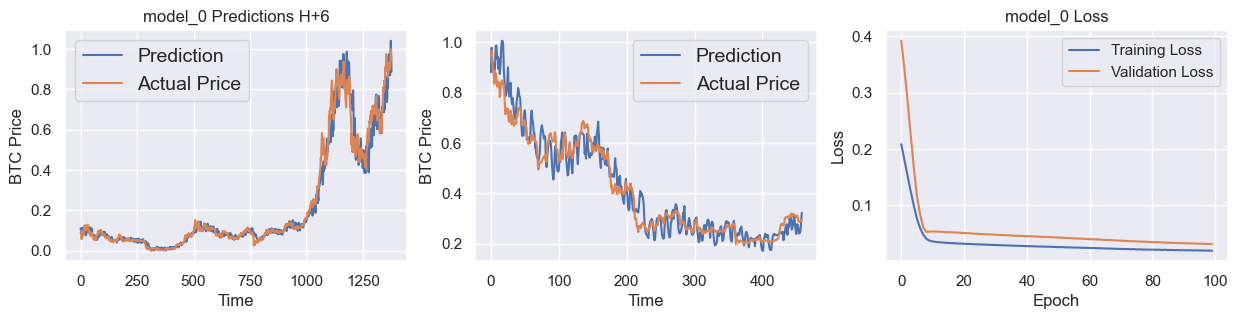

In [310]:
tf.random.set_seed(42)
model_0_history = train_model(
    model=model_0,
    model_name='model_0',
    loss_fn=loss_fn,
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics,
    X_train=X_train,
    y_train=y_train, 
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    shuffle=False,
    verbose=0,
    callbacks=callback
)
fast_save(model_0, 'model_0_LSTM')

## GRU

In [311]:
tf.random.set_seed(42)
model_1 = Sequential([
    GRU(units=64, 
         input_shape=(1, X_train.shape[2]), 
         activation='relu'),
    Dense(units=7)
])

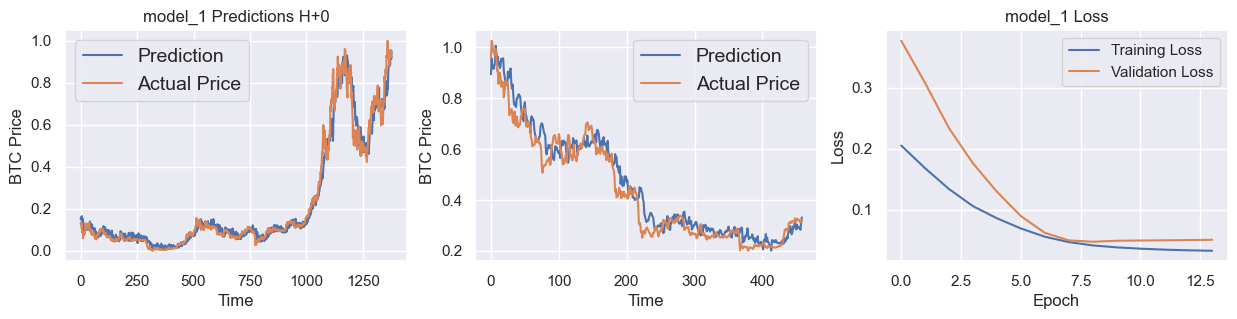

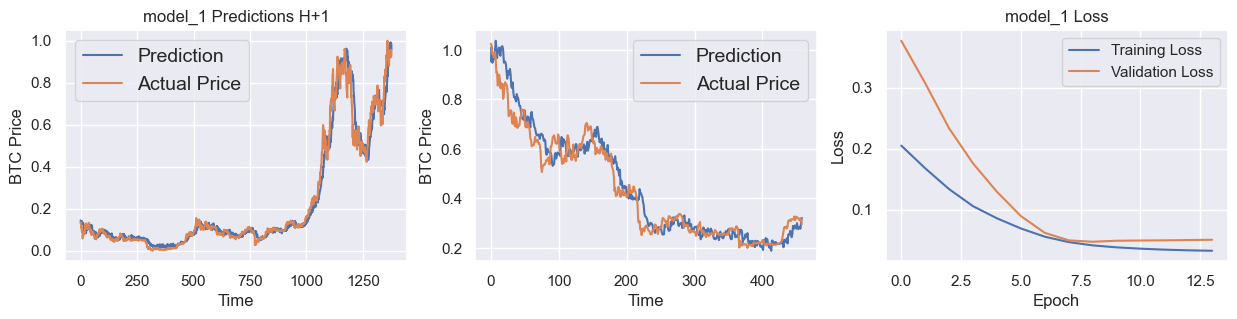

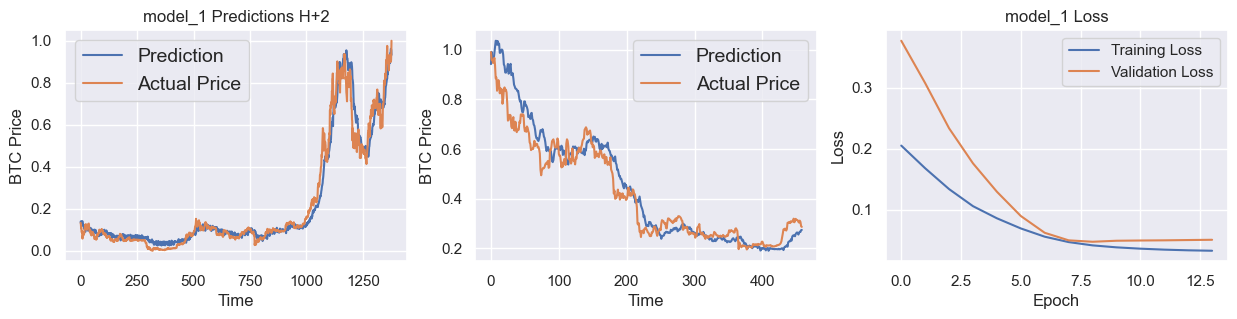

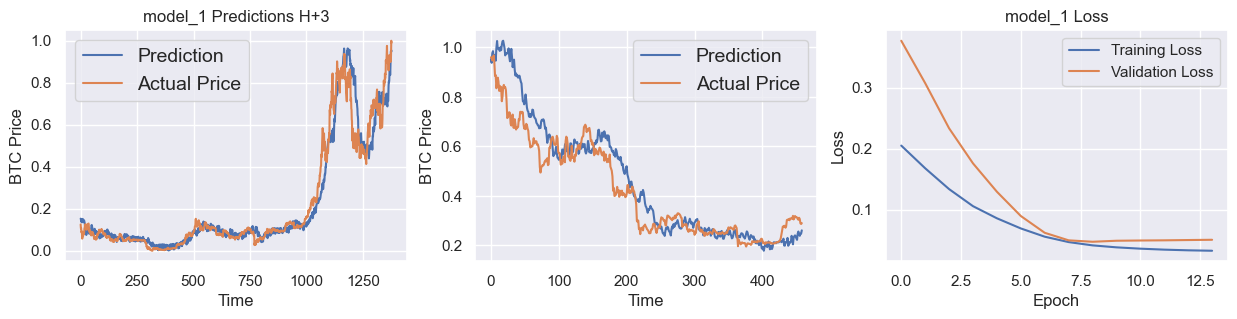

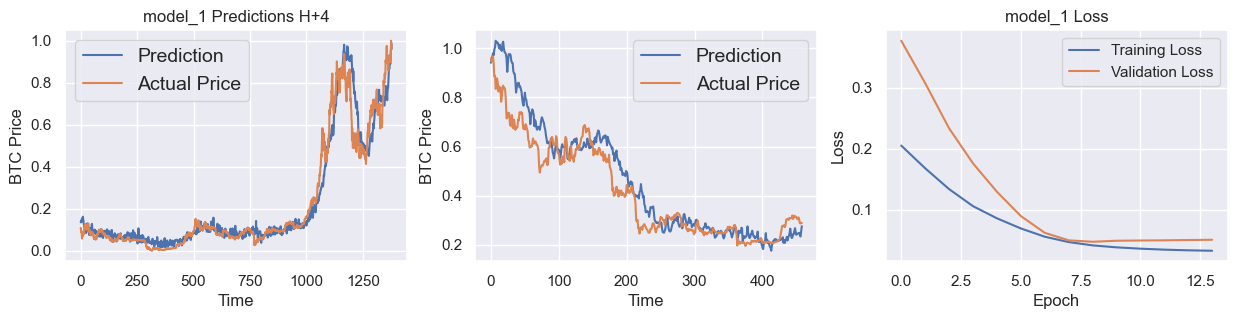

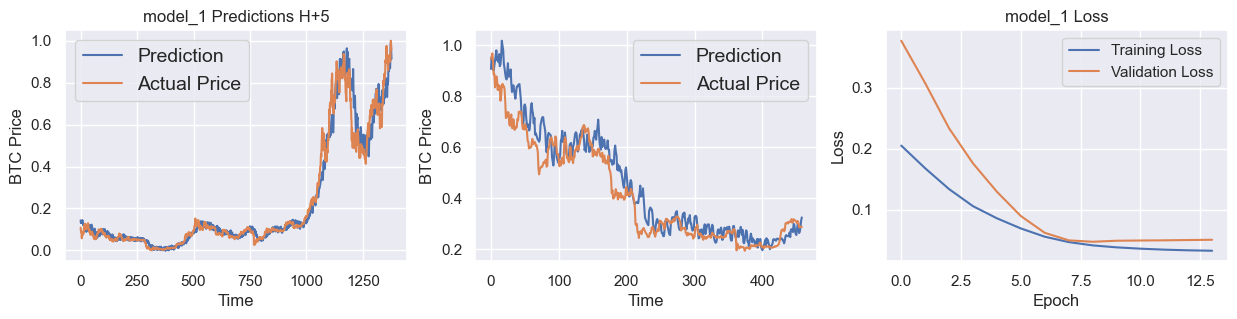

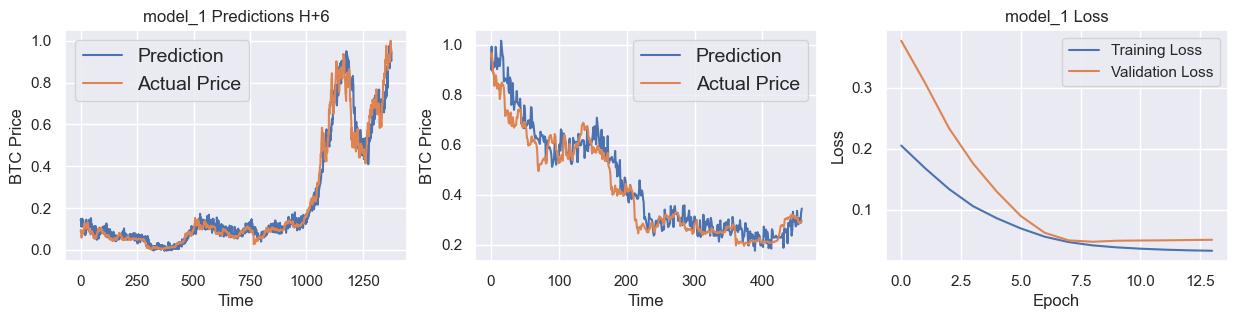

In [312]:
tf.random.set_seed(42)
model_1_history = train_model(
    model=model_1,
    model_name='model_1',
    loss_fn=loss_fn,
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics,
    X_train=X_train,
    y_train=y_train, 
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    shuffle=False,
    verbose=0,
    callbacks=callback
)
fast_save(model_1, 'model_1_GRU')

## CNN

In [313]:
tf.random.set_seed(42)
model_2 = Sequential([
    Conv1D(
         filters=64,
         kernel_size=1, 
         activation='relu',
         input_shape=(1, X_train.shape[2]),
    ),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(20, activation='relu'),
    Dense(7)
])

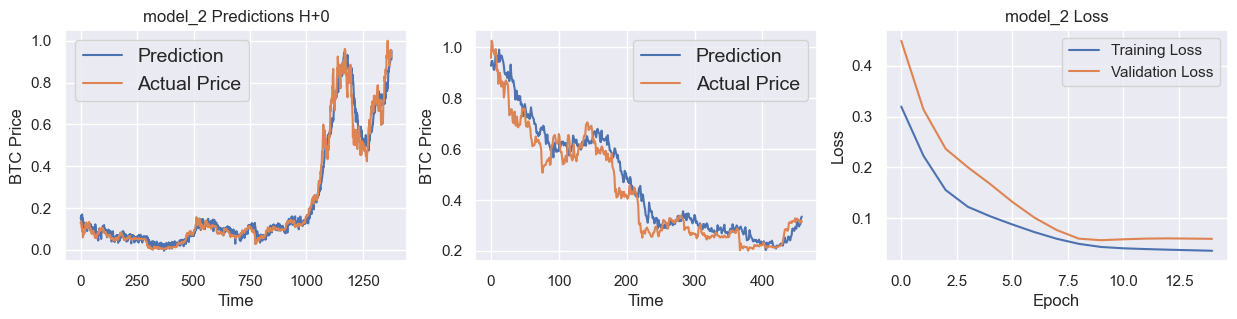

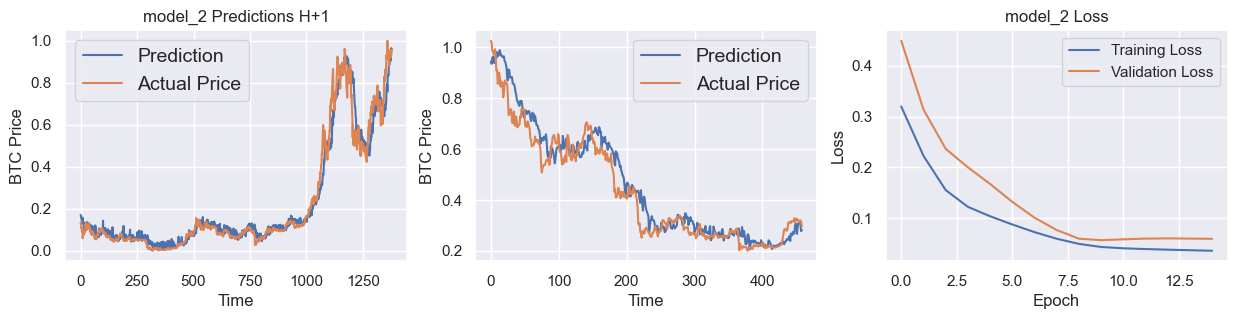

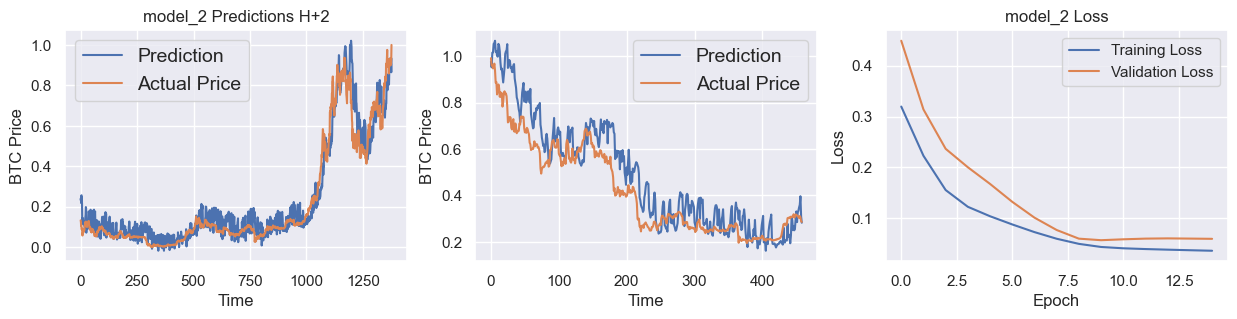

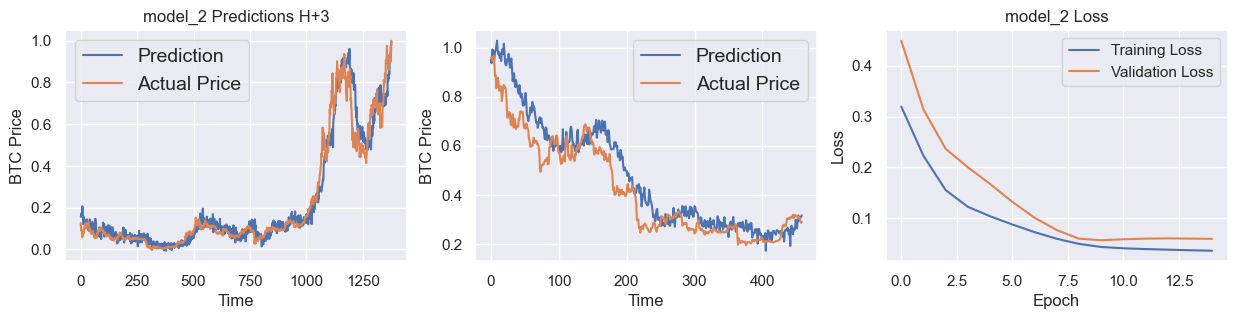

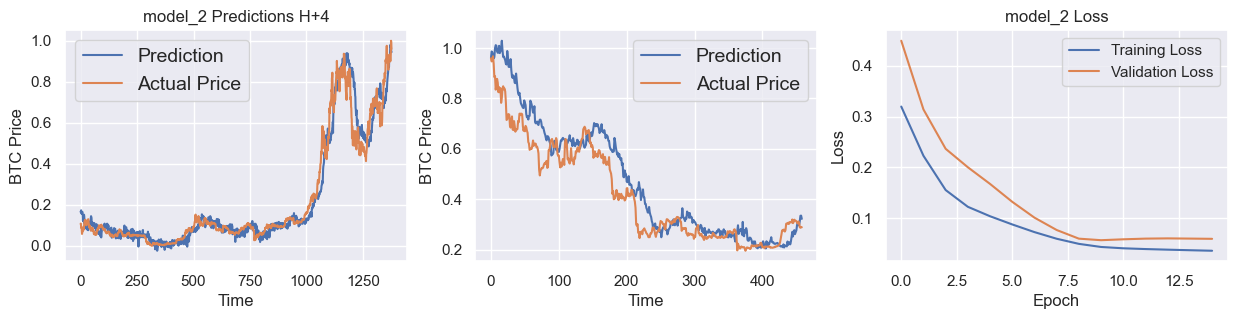

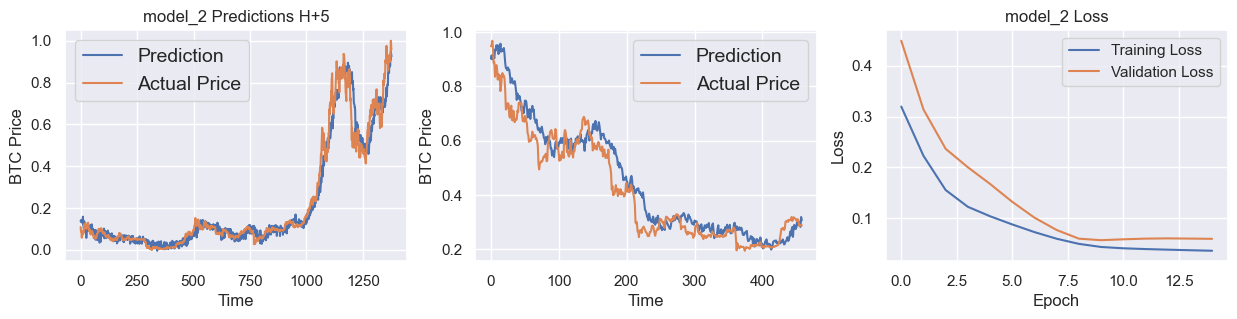

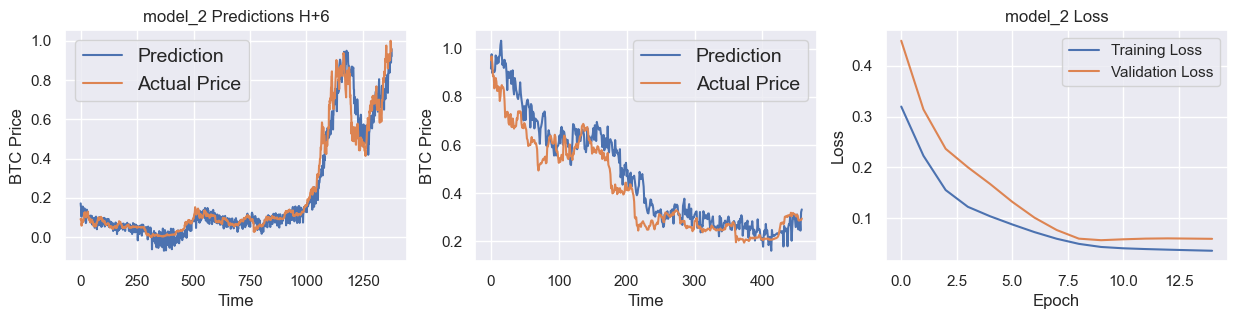

In [314]:
tf.random.set_seed(42)
model_2_history = train_model(
    model=model_2,
    model_name='model_2',
    loss_fn=loss_fn,
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics,
    X_train=X_train,
    y_train=y_train, 
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    shuffle=False,
    verbose=0,
    callbacks=callback
)
fast_save(model_2, 'model_2_CNN')

## Comparison of each model

### Train

In [315]:
train_res_dir = 'results/with_technical_indicators/train'
train_results = get_results_table(train_res_dir)
train_results

,mae,mse,rmse,mape,mase,model
0,0.019067,0.001289,0.020983,2510.932129,2.461432,model_0_LSTM
1,0.031331,0.002941,0.034807,20226.511719,4.044556,model_1_GRU
2,0.035247,0.003316,0.040561,13106.329102,4.550069,model_2_CNN


### Valid

In [316]:
valid_res_dir = 'results/with_technical_indicators/valid'
valid_results = get_results_table(valid_res_dir)
valid_results

,mae,mse,rmse,mape,mase,model
0,0.031244,0.001843,0.034490,7.548938,2.851309,model_0_LSTM
1,0.050334,0.004791,0.055396,12.022082,4.593540,model_1_GRU
2,0.059683,0.006246,0.066107,14.758455,5.446748,model_2_CNN


# Testing

## LSTM

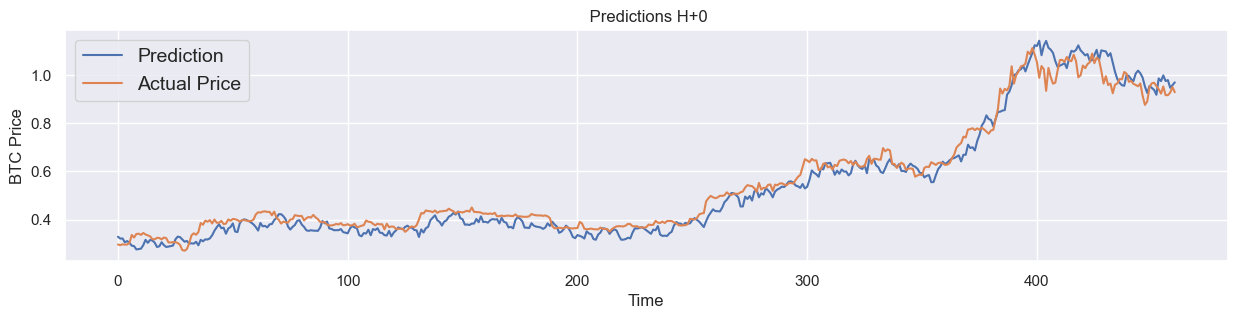

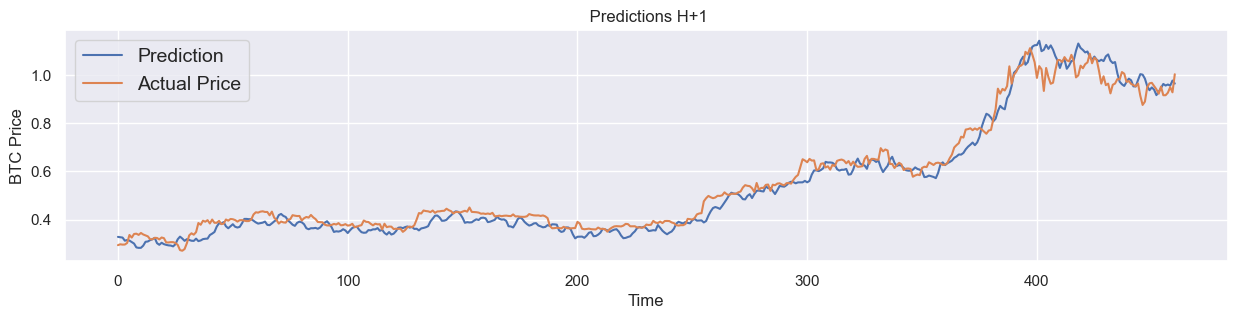

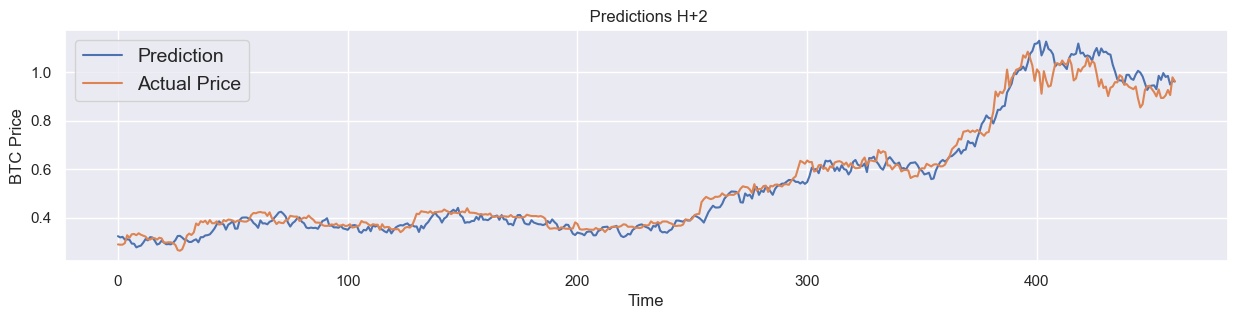

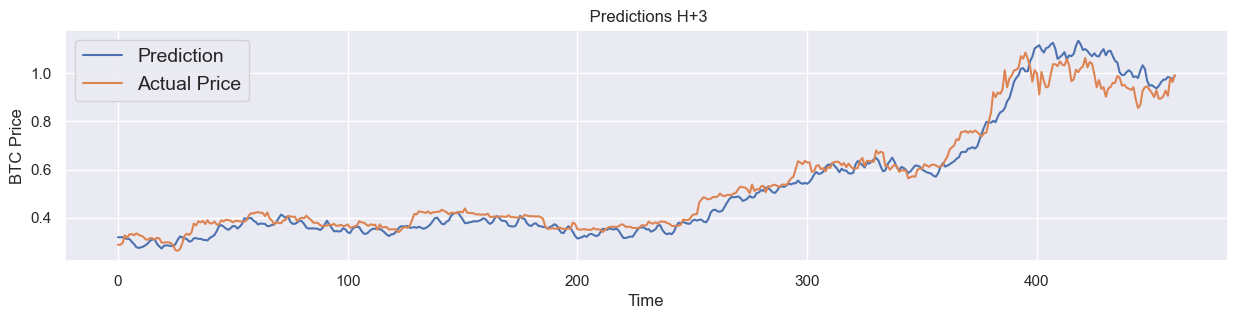

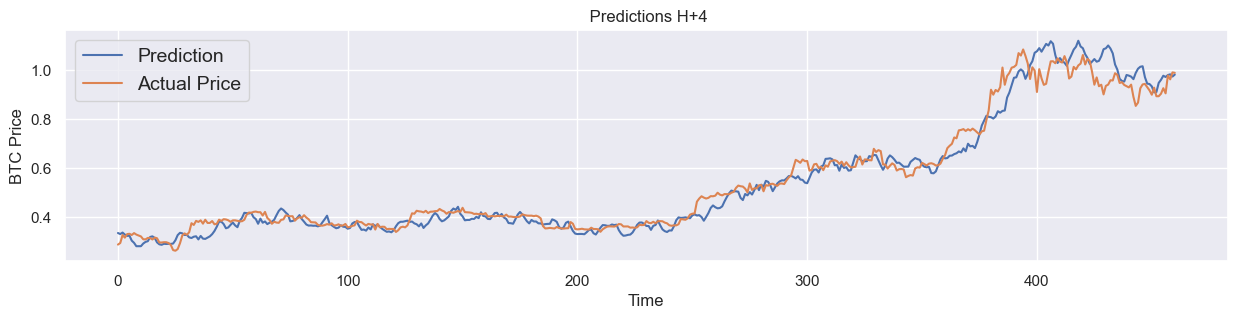

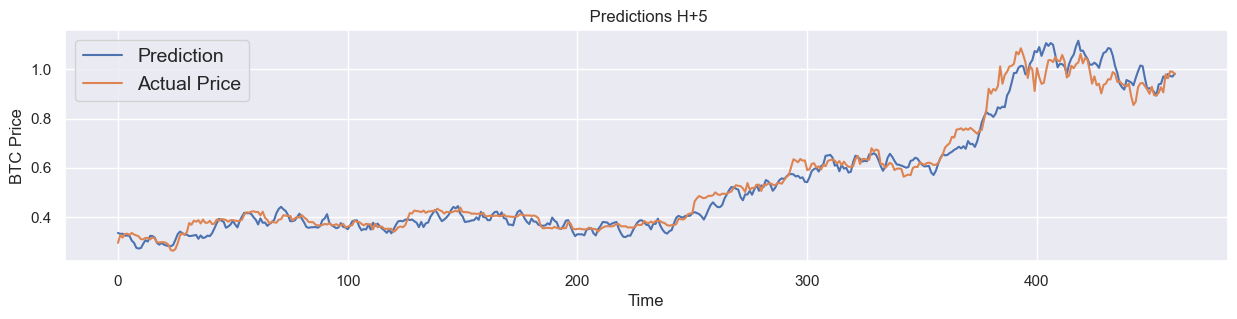

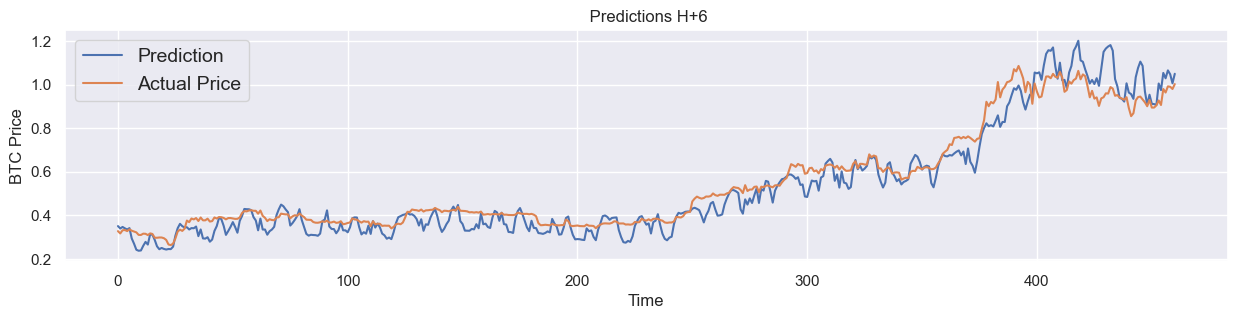

In [317]:
plot_loss_and_prediction(model_0,
                         X_test,
                         y_test)

## GRU

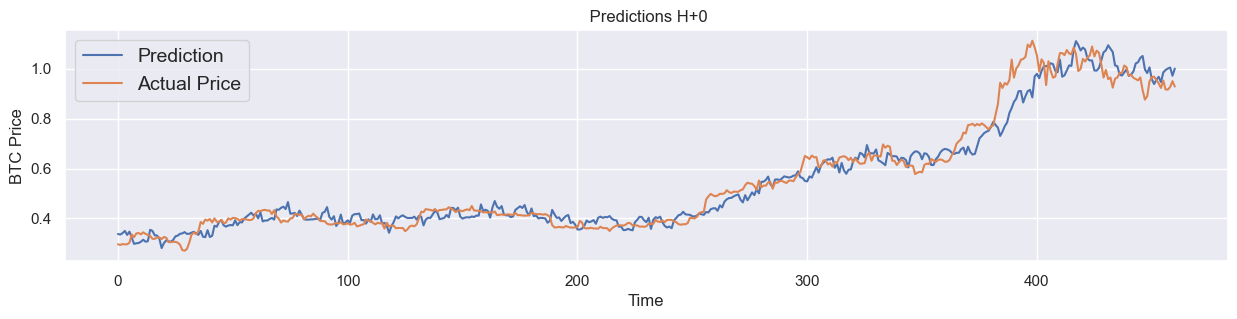

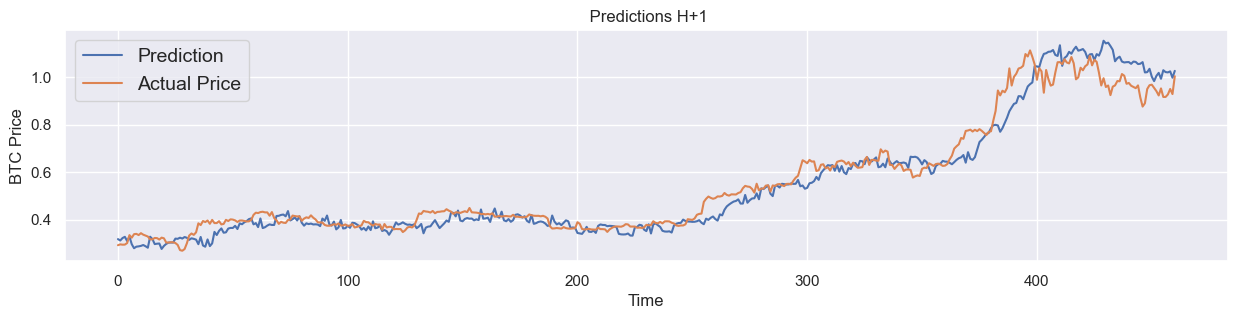

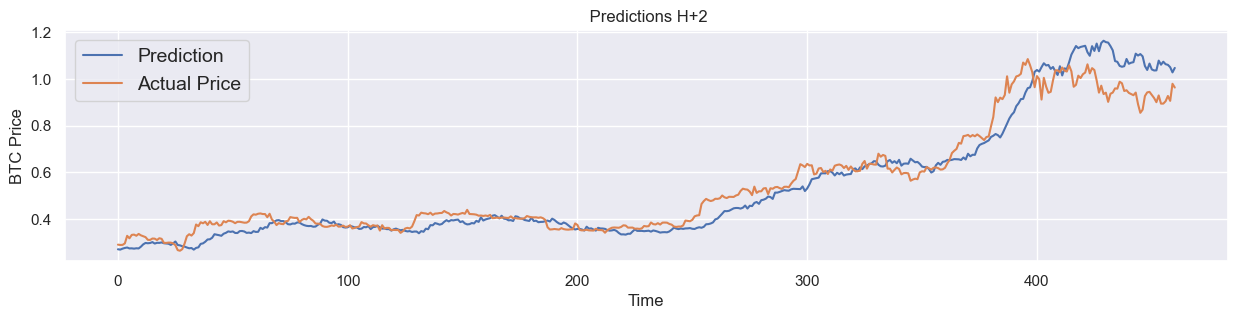

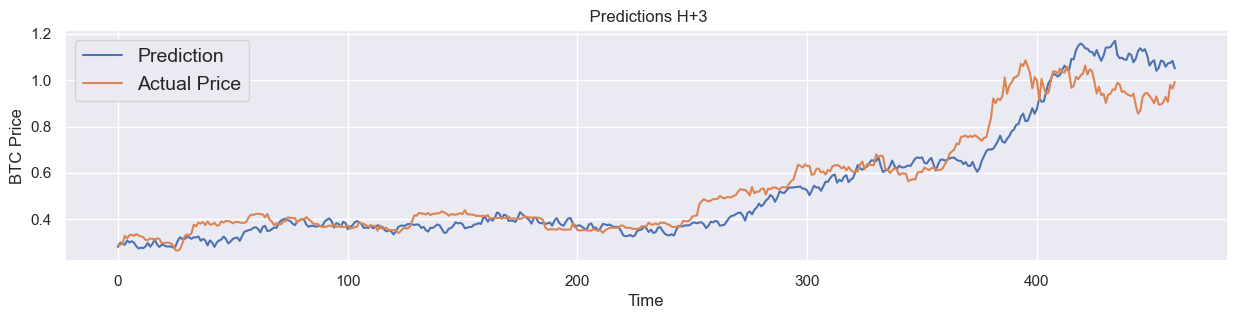

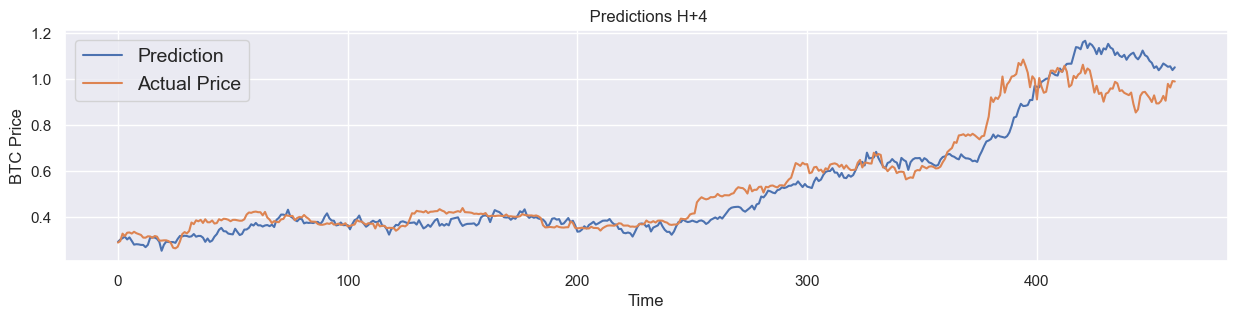

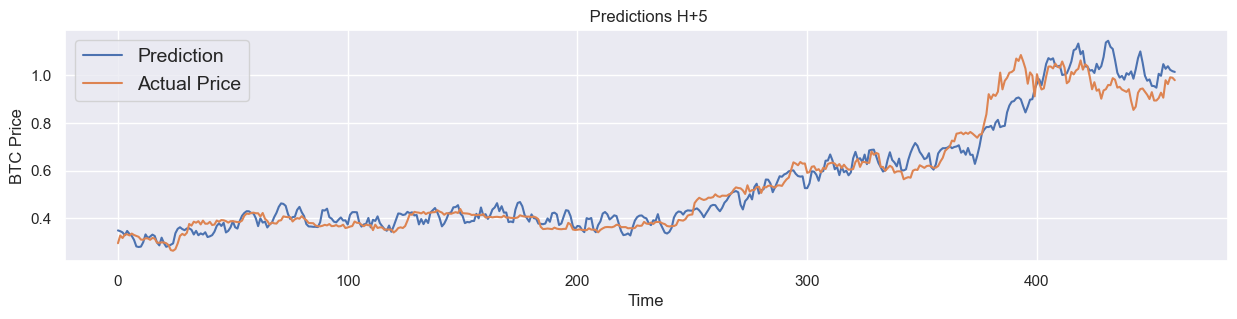

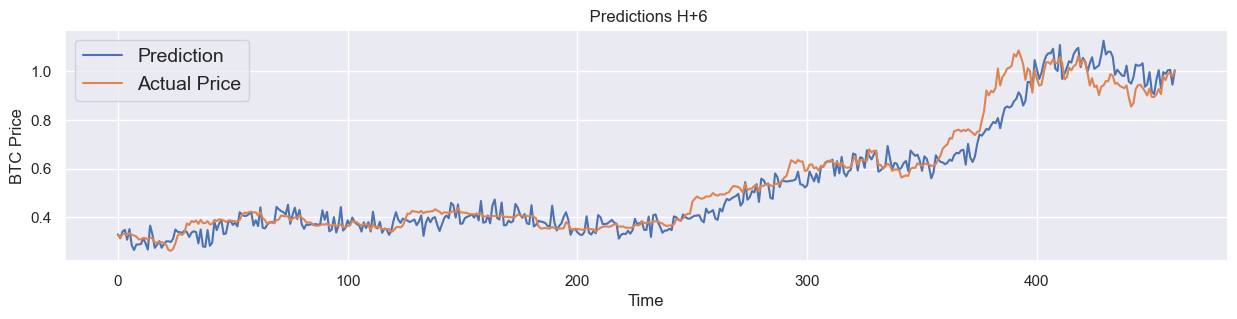

In [318]:
plot_loss_and_prediction(model_1,
                         X_test,
                         y_test)

## CNN

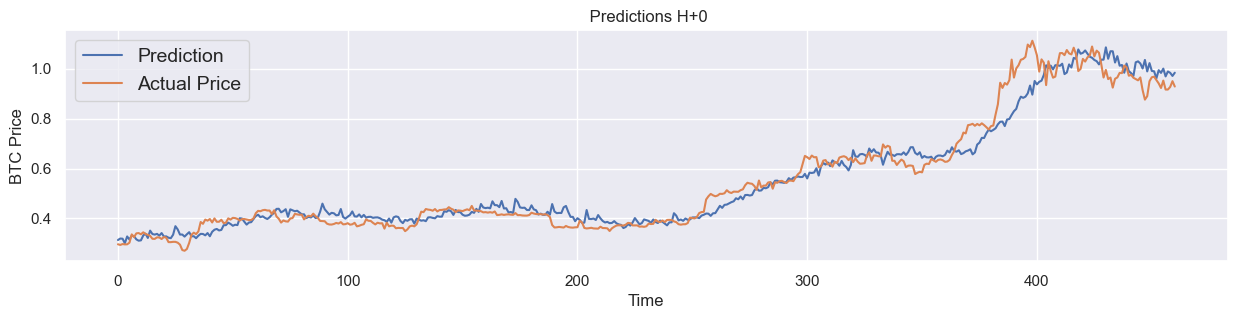

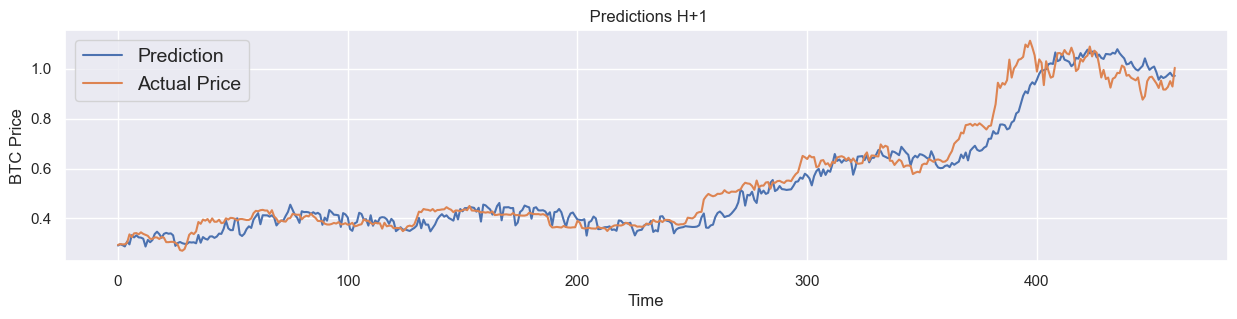

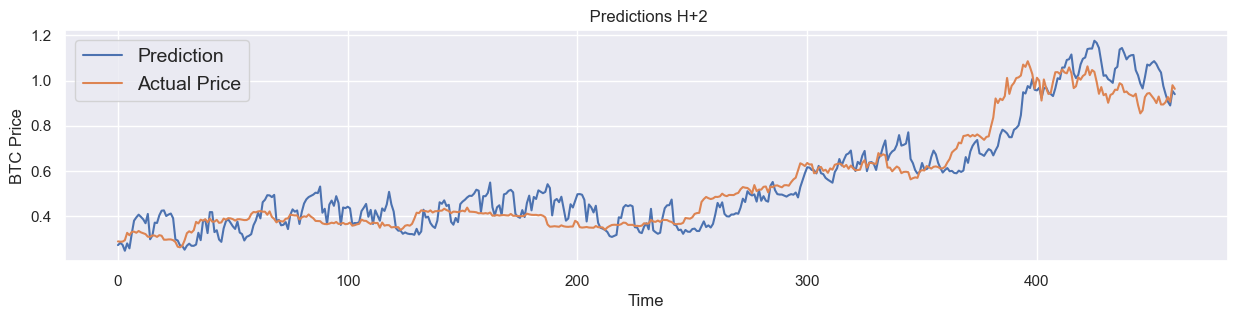

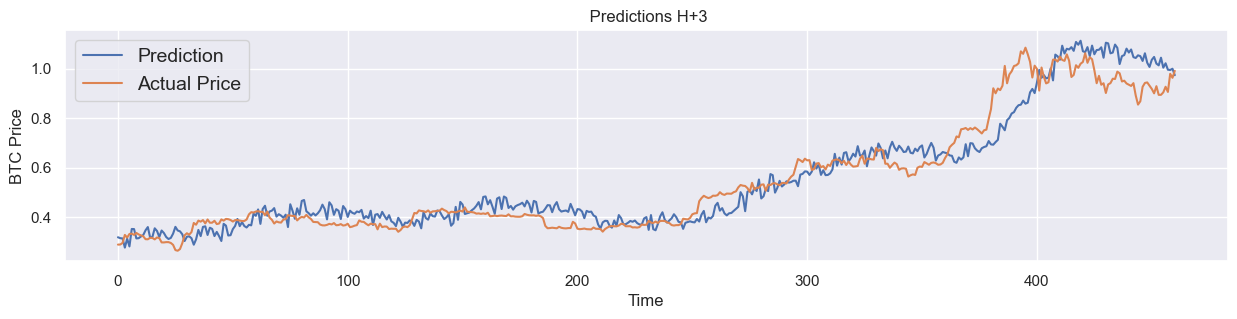

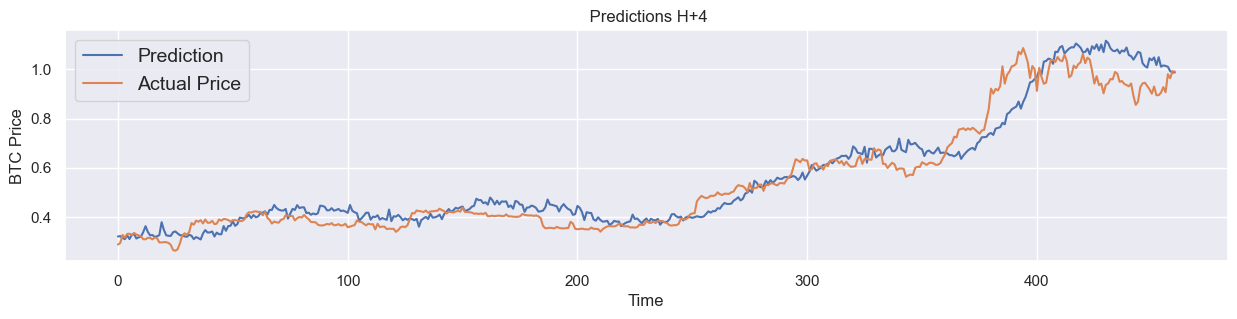

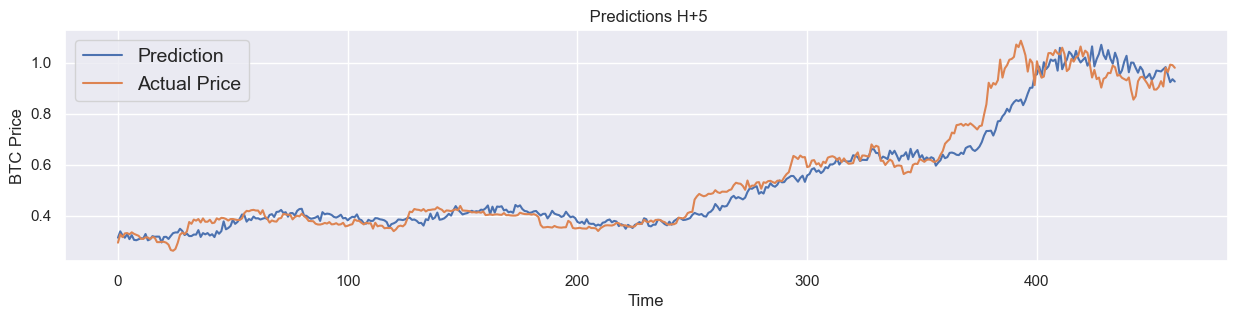

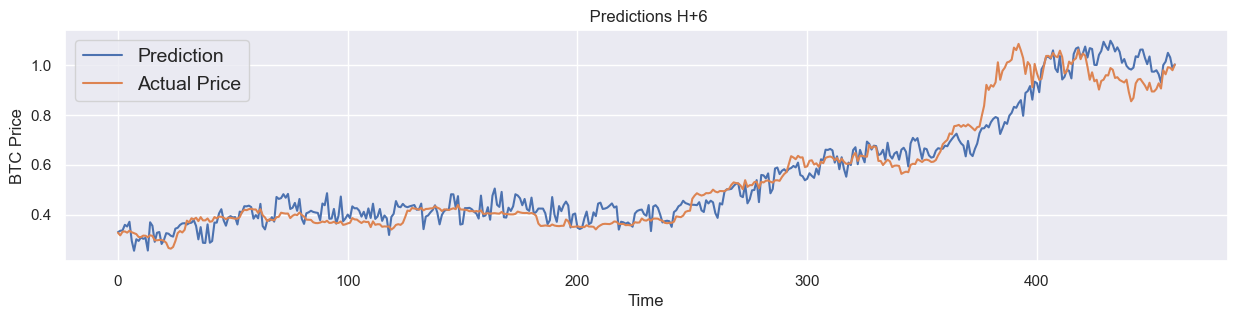

In [319]:
plot_loss_and_prediction(model_2,
                         X_test,
                         y_test)

## Comparison of each model

In [320]:
test_res_dir = 'results/with_technical_indicators/test'
test_results = get_results_table(test_res_dir)
test_results

,mae,mse,rmse,mape,mase,model
0,0.035067,0.002225,0.038305,6.507417,3.121811,model_0_LSTM
1,0.044950,0.004053,0.050209,7.778176,4.001585,model_1_GRU
2,0.047086,0.004081,0.053725,8.691756,4.191751,model_2_CNN
